# **[Kaggle Notebook] Dự đoán Giá nhà - Một Chiến lược Toàn diện**
Trong notebook này, chúng ta sẽ thực hiện một quy trình hoàn chỉnh từ A-Z:
- Khám phá dữ liệu (EDA)
- Xử lý dữ liệu và Feature Engineering (Đây là phần quan trọng nhất!)
- Xây dựng và Huấn luyện mô hình
- Ensemble (Kết hợp) nhiều mô hình để có kết quả tốt nhất.

# **1. Khởi tạo: Tải thư viện và Dữ liệu**

In [2]:
# Tải các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Thư viện mô hình
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

# Tắt cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

# Tải dữ liệu
try:
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp train.csv hoặc test.csv.")
    # Ở đây bạn có thể thêm code để tải từ URL nếu muốn
    # Ví dụ:
    # train = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3014/25232/bundle/archive/train.csv?GoogleAccessId=web-data-project-153307@appspot.gserviceaccount.com&Expires=1731456983&Signature=...')
    # (Lưu ý: URL này có thể không hoạt động vĩnh viễn)

# Lưu ID của tập test để dùng cho file nộp bài
test_ID = test['Id']

# In ra kích thước dữ liệu
print(f"Kích thước tập huấn luyện: {train.shape}")
print(f"Kích thước tập kiểm tra: {test.shape}")

Kích thước tập huấn luyện: (1460, 81)
Kích thước tập kiểm tra: (1459, 80)


# **2. Phân tích và Xử lý Biến mục tiêu (SalePrice)**
Chỉ số đánh giá là RMSLE (Root Mean Squared Logarithmic Error). Điều này gợi ý rằng chúng ta nên lấy `log` của biến `SalePrice`.

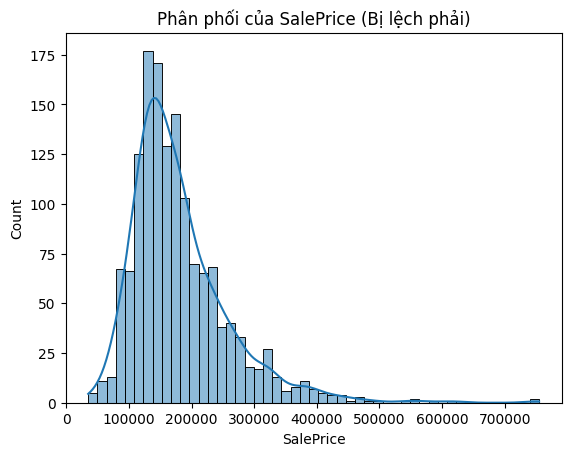

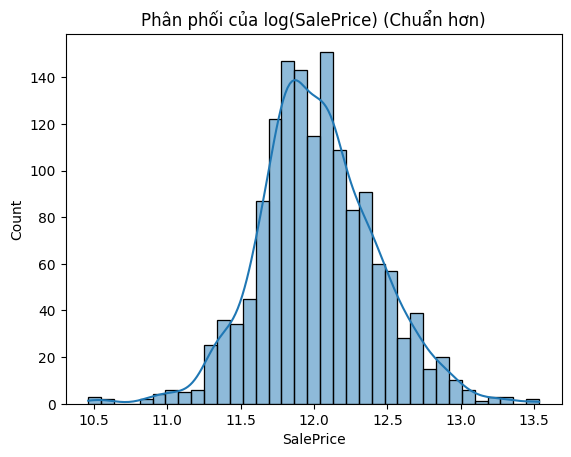

In [3]:
# 1. Vẽ đồ thị phân phối của SalePrice
sns.histplot(train['SalePrice'], kde=True)
plt.title('Phân phối của SalePrice (Bị lệch phải)')
plt.show()

# 2. Áp dụng Log Transform (sử dụng log1p để tránh log(0))
train['SalePrice'] = np.log1p(train['SalePrice'])

# 3. Vẽ lại đồ thị sau khi biến đổi
sns.histplot(train['SalePrice'], kde=True)
plt.title('Phân phối của log(SalePrice) (Chuẩn hơn)')
plt.show()

# **3. Feature Engineering và Xử lý Dữ liệu**
Đây là bước quan trọng nhất. Chúng ta sẽ kết hợp `train` và `test` để xử lý đồng nhất.

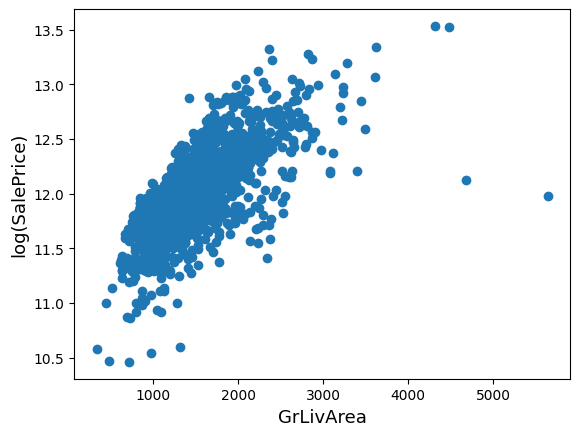

Kích thước tổng cộng: (2917, 79)
Vẫn còn giá trị thiếu!
Kích thước cuối cùng sau khi xử lý: (2917, 301)


In [4]:
# 1. Xác định và loại bỏ outliers (Điểm dị biệt)
# Dựa trên phân tích phổ biến, có 2 điểm dữ liệu GrLivArea > 4000
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('log(SalePrice)', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Loại bỏ outliers khỏi tập train
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 12.5)].index)

# 2. Kết hợp train và test
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train['SalePrice'].values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.drop(['Id'], axis=1, inplace=True)

print(f"Kích thước tổng cộng: {all_data.shape}")

# 3. Xử lý giá trị bị thiếu (Missing Values)
# Chiến lược: Một số 'NA' có ý nghĩa (ví dụ: 'NA' trong PoolQC nghĩa là 'Không có bể bơi')
# Chúng ta sẽ điền 'None' cho categorical và 0 cho numerical

# Các cột mà 'NA' có nghĩa là "None" (Không có)
cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'MasVnrType']

for col in cols_fill_none:
    all_data[col] = all_data[col].fillna('None')

# Các cột mà 'NA' có nghĩa là 0
cols_fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                  'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in cols_fill_zero:
    all_data[col] = all_data[col].fillna(0)

# Các cột 'NA' thực sự bị thiếu -> Điền bằng giá trị phổ biến nhất (mode)
cols_fill_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']

for col in cols_fill_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Cột 'LotFrontage' (Khoảng cách tới đường): Điền bằng median của khu vực (Neighborhood)
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Kiểm tra lại xem còn thiếu không
if all_data.isnull().values.sum() > 0:
    print("Vẫn còn giá trị thiếu!")
else:
    print("Đã xử lý xong tất cả giá trị thiếu.")

# 4. Biến đổi các đặc trưng bị lệch (Skewed Features)
# Tìm các đặc trưng số
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Tính độ lệch
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75] # Chỉ chọn các cột lệch nhiều
skewed_cols = skewed_feats.index

# Áp dụng log(x+1) transform
for col in skewed_cols:
    all_data[col] = np.log1p(all_data[col])

# 5. Mã hóa Biến Categorical (One-Hot Encoding)
# Biến các đặc trưng dạng chữ thành số để mô hình hiểu được
all_data = pd.get_dummies(all_data)

print(f"Kích thước cuối cùng sau khi xử lý: {all_data.shape}")

# 6. Tách lại tập train và test
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

# **4. Xây dựng và Đánh giá Mô hình**
Chúng ta sẽ dùng Cross-Validation (Kiểm tra chéo) để đánh giá mô hình. Chúng ta sẽ tính điểm RMSE (trên dữ liệu đã log-transform).

In [5]:
# Định nghĩa hàm tính điểm Cross-Validation
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    # Lưu ý: metric là 'neg_mean_squared_error', chúng ta lấy âm và căn bậc 2
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train,
                                    scoring="neg_mean_squared_error", cv=kf))
    return rmse

# --- Mô hình 1: LASSO Regression ---
# Lasso rất tốt vì nó có thể tự động chọn đặc trưng (đưa hệ số về 0)
# Chúng ta dùng LassoCV để tự động tìm alpha (hệ số điều chuẩn) tốt nhất
lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0005, 0.001, 0.01, 0.1, 1, 10],
                random_state=42,
                cv=n_folds)
lasso.fit(X_train, y_train)
score_lasso = rmsle_cv(lasso)
print(f"Lasso CV RMSE: {score_lasso.mean():.4f} (std: {score_lasso.std():.4f})")


# --- Mô hình 2: LightGBM ---
# Một mô hình Gradient Boosting rất nhanh và hiệu quả
lgbm = lgb.LGBMRegressor(objective='regression',
                         num_leaves=5,
                         learning_rate=0.05,
                         n_estimators=720,
                         max_bin=55,
                         bagging_fraction=0.8,
                         bagging_freq=5,
                         feature_fraction=0.2319,
                         feature_fraction_seed=9,
                         bagging_seed=9,
                         min_data_in_leaf=6,
                         min_sum_hessian_in_leaf=11,
                         random_state=42)

score_lgbm = rmsle_cv(lgbm)
print(f"LightGBM CV RMSE: {score_lgbm.mean():.4f} (std: {score_lgbm.std():.4f})")

# --- Mô hình 3: XGBoost ---
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603,
                             gamma=0.0468,
                             learning_rate=0.05,
                             max_depth=3,
                             min_child_weight=1.7817,
                             n_estimators=2200,
                             reg_alpha=0.4640,
                             reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state=42,
                             nthread=-1)

score_xgb = rmsle_cv(xgboost)
print(f"XGBoost CV RMSE: {score_xgb.mean():.4f} (std: {score_xgb.std():.4f})")

Lasso CV RMSE: 0.1102 (std: 0.0066)
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: 

# **5. Ensemble (Kết hợp) và Nộp bài**
Chúng ta sẽ lấy trung bình có trọng số (weighted average) của các mô hình. Mô hình nào có điểm CV tốt hơn (RMSE thấp hơn) thì sẽ được trọng số cao hơn.

In [6]:
# Huấn luyện mô hình trên toàn bộ dữ liệu train
print("Đang huấn luyện mô hình Lasso...")
lasso.fit(X_train, y_train)

print("Đang huấn luyện mô hình LightGBM...")
lgbm.fit(X_train, y_train)

print("Đang huấn luyện mô hình XGBoost...")
xgboost.fit(X_train, y_train)

# Lấy dự đoán (trên thang log)
lasso_pred = lasso.predict(X_test)
lgbm_pred = lgbm.predict(X_test)
xgb_pred = xgboost.predict(X_test)

# Kết hợp (Ensemble) - Bạn có thể điều chỉnh các trọng số này
# Ví dụ: 60% LGBM, 20% XGBoost, 20% Lasso
ensemble_pred = (0.2 * lasso_pred) + (0.6 * lgbm_pred) + (0.2 * xgb_pred)

# Chuyển đổi ngược từ log về giá trị ban đầu
final_pred = np.expm1(ensemble_pred)

# Tạo tệp nộp bài
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = final_pred
submission.to_csv('submission.csv', index=False)

print("Đã tạo tệp submission.csv thành công!")

Đang huấn luyện mô hình Lasso...
Đang huấn luyện mô hình LightGBM...
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value:

**Điểm của submission.csv trên Kaggle Competition: 0.12315**